In [1]:
import pandas as pd
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'

# 1. Using iterators to load large files into memory

## 1.1 Processing large amounts of Twitter data

In [2]:
counts_dict = {}

# Iterate over the file chunk by chunk
for chunk in pd.read_csv('./datasets/tweets.csv', chunksize=10):
    for entry in chunk['lang']:
        if entry in counts_dict.keys():
            counts_dict[entry] += 1
        else:
            counts_dict[entry] = 1
    
print(counts_dict)

{'et': 1, 'und': 2, 'en': 97}


## 1.2 Extracting information for large amounts of Twitter data

In [3]:
def count_entries(csv_file, c_size, colname):
    """Return a dictionary with counts of occurences as value for each key."""
    
    counts_dict = {}
    
    for chunk in pd.read_csv(csv_file, chunksize=c_size):
        for entry in chunk[colname]:
            if entry in counts_dict.keys():
                counts_dict[entry] += 1
            else:
                counts_dict[entry] = 1
    return counts_dict

result_counts = count_entries('./datasets/tweets.csv', 10, 'lang')

print(result_counts)

{'et': 1, 'und': 2, 'en': 97}


# 2. Using pandas 'read_csv' iterator for streaming data

## 2.1 Writing an iterator to load data in chunks

### 2.1.1 Reading the file as an iterable 'reader object' in as DataFrames of a certain length.

In [4]:
# Initializer reader object: df_reader
df_reader = pd.read_csv('./datasets/world_ind_pop_data.csv',
                        chunksize=10)

print(next(df_reader))
print(next(df_reader))

                                 CountryName CountryCode  Year  \
0                                 Arab World         ARB  1960   
1                     Caribbean small states         CSS  1960   
2             Central Europe and the Baltics         CEB  1960   
3    East Asia & Pacific (all income levels)         EAS  1960   
4      East Asia & Pacific (developing only)         EAP  1960   
5                                  Euro area         EMU  1960   
6  Europe & Central Asia (all income levels)         ECS  1960   
7    Europe & Central Asia (developing only)         ECA  1960   
8                             European Union         EUU  1960   
9   Fragile and conflict affected situations         FCS  1960   

   Total Population  Urban population (% of total)  
0      9.249590e+07                      31.285384  
1      4.190810e+06                      31.597490  
2      9.140158e+07                      44.507921  
3      1.042475e+09                      22.471132  
4      8

### 2.1.2 Reading in a file using a bigger DataFram chunk size and processing the data from the first chunk

In [5]:
urb_pop_reader = pd.read_csv('./datasets/world_ind_pop_data.csv',
                             chunksize=10)

# Get the first dataframe chunk: df_urb_pop
df_urb_pop = next(urb_pop_reader)
print(df_urb_pop.head())

df_pop_ceb = df_urb_pop[df_urb_pop['CountryCode']=='CEB']

# Zip dataframe columns of interest: pops
pops = zip(df_pop_ceb['Total Population'], 
           df_pop_ceb['Urban population (% of total)'])

# Turn zip object into list: pops_list
pops_list = list(pops)

                               CountryName CountryCode  Year  \
0                               Arab World         ARB  1960   
1                   Caribbean small states         CSS  1960   
2           Central Europe and the Baltics         CEB  1960   
3  East Asia & Pacific (all income levels)         EAS  1960   
4    East Asia & Pacific (developing only)         EAP  1960   

   Total Population  Urban population (% of total)  
0      9.249590e+07                      31.285384  
1      4.190810e+06                      31.597490  
2      9.140158e+07                      44.507921  
3      1.042475e+09                      22.471132  
4      8.964930e+08                      16.917679  


### 2.1.3 Creating the values for a new column by using a list comprehension

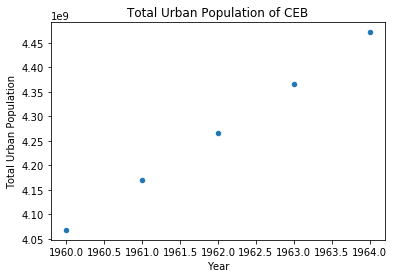

In [6]:
# Initialize reader object: urb_pop_reader
urb_pop_reader = pd.read_csv('./datasets/world_ind_pop_data.csv',
                             chunksize=1000)

# Get the first dataframe chunk: df_urb_pop
df_urb_pop = next(urb_pop_reader)

# Check out specific country: df_pop_ceb
df_pop_ceb = df_urb_pop[df_urb_pop['CountryCode'] == 'CEB']

# Zip dataframe columns of interest: pops
pops = zip(df_pop_ceb['Total Population'], 
            df_pop_ceb['Urban population (% of total)'])

# Turn zip object into list: pops_list
pops_list = list(pops)

# Use list comprehension to create new dataframe column 
# 'Total Urban Population'
df_pop_ceb['Total Urban Population'] = [int(tup[0] * tup[1]) \
                                        for tup in pops_list]

# Plot urban population data
df_pop_ceb.plot(kind='scatter', 
                x='Year', 
                y='Total Urban Population',
                title='Total Urban Population of CEB')
plt.show()


### 2.1.4 Aggregating the results over all the DataFrame chunks in the dataset

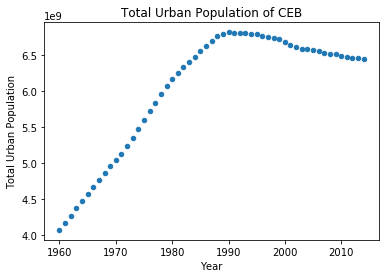

In [7]:
# Initialize reader object: urb_pop_reader
urb_pop_reader = pd.read_csv('./datasets/world_ind_pop_data.csv',
                             chunksize=1000)

# Initialize empty dataframe: data
data = pd.DataFrame()

# Iterate over each dataframe chunk
for df_urb_pop in urb_pop_reader:
    df_pop_ceb = df_urb_pop[df_urb_pop['CountryCode'] == 'CEB']
    
    pops = zip(df_pop_ceb['Total Population'],
               df_pop_ceb['Urban population (% of total)'])
    
    pops_list = list(pops)
    
    # Use list comprehension to create new dataframe column 
    # 'Total Urban Population'
    df_pop_ceb['Total Urban Population'] = [int(tup[0] * tup[1]) \
                                            for tup in pops_list]
    
    # Append dataframe chunk to data: data
    data = data.append(df_pop_ceb)
    
data.plot(kind='scatter',
          x='Year',
          y='Total Urban Population',
          title='Total Urban Population of CEB')
plt.show()

### 2.1.5 Putting all the code for processing the data into a single function

In [8]:
def plot_pop(filename, country_code):
    """ Loading of the file chunk by chunk
        Creating the new column of urban population values
        Plotting the urban population data.
        
        Arguments:
        filename: the filename of the file to be processed
        country_code: the country code of the rows to 
        process in the dataset """
    urb_pop_reader = pd.read_csv(filename, chunksize=1000)
    
    data = pd.DataFrame()
    
    for df_urb_pop in urb_pop_reader:
        df_pop_cc = df_urb_pop[df_urb_pop['CountryCode'] \
                               == country_code]
        pops = zip(df_pop_cc['Total Population'],
                   df_pop_cc['Urban population (% of total)'])
        pops_list = list(pops)
        
        df_pop_cc['Total Urban Population'] = \
        [int(tup[0] * tup[1]) for tup in pops_list]
        
        data = data.append(df_pop_cc)
        
    data.plot(kind='scatter', 
              x='Year', 
              y='Total Urban Population', 
              title='Total Urban Population of {}'\
              .format(country_code))
    plt.show()

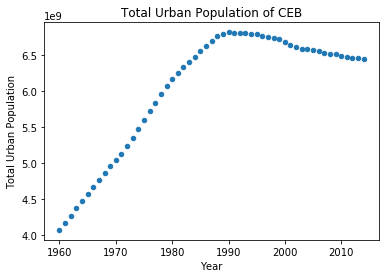

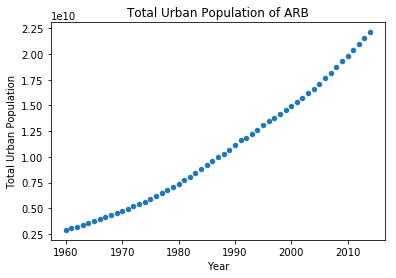

In [9]:
fn = './datasets/world_ind_pop_data.csv'

plot_pop(fn, 'CEB')

plot_pop(fn, 'ARB')